In [5]:
import numpy as np 
import pandas as pd
import timm 
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import time
import os
import torchvision.transforms as T
from torch.amp import autocast
from matplotlib import pyplot as plt
from kornia import tensor_to_image
from kornia.contrib import extract_tensor_patches, compute_padding
import csv
from open_clip import create_model, get_tokenizer

In [6]:
df_species_ids = pd.read_csv('./species_ids.csv')

df_metadata = pd.read_csv('./PlantCLEF2024_single_plant_training_metadata.csv', sep=';', dtype={'partner': str})
class_map = df_species_ids['species_id'].to_dict() # dictionary to map the species model Id with the species Id
id_to_species = df_metadata[['species_id', 'species']].drop_duplicates().set_index('species_id')
id_to_species_dict = id_to_species['species'].to_dict()

In [7]:
device = torch.device('cuda')
model = timm.create_model('vit_base_patch14_reg4_dinov2.lvd142m',
                          pretrained=False,
                          num_classes=len(df_species_ids),
                          checkpoint_path='./pretrain_model/vit_base_patch14_reg4_dinov2_lvd142m_pc24_onlyclassifier_then_all/model_best.pth.tar')
model = model.to(device)
model = model.eval()

In [9]:
data_config = timm.data.resolve_model_data_config(model)
model_input_size, model_mean, model_std = data_config['input_size'][1], data_config['mean'], data_config['std']

batch_size = 64
min_score = 0.1
top_k_tile = 5
patch_size = model_input_size
stride = int(model_input_size / 2)
use_pad = True

In [10]:
img = Image.open('./PlantCLEF2025_test_images/PlantCLEF2025_test_images/GUARDEN-CBNMed-30-4-16-3-20240428.jpg')
image_to_tensor = T.ToTensor()

image_tensor = image_to_tensor(img).unsqueeze(0)
h, w = image_tensor.shape[-2:]

pad = compute_padding(original_size=(h, w), window_size=patch_size, stride=stride)

patches = extract_tensor_patches(image_tensor, patch_size, stride, padding=pad)
print(f"Shape of image tiles = {patches.shape}")

Shape of image tiles = torch.Size([1, 64, 3, 518, 518])


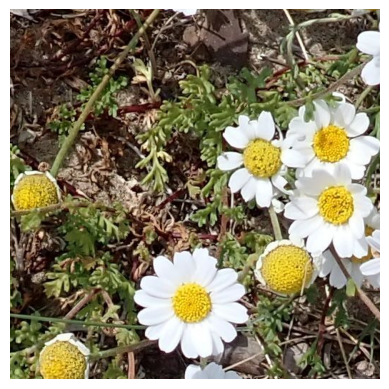

In [11]:
fig, axs = plt.subplots(1, 1)
axs.axis("off")
axs.imshow(tensor_to_image(patches[0][29]))

plt.show()

In [12]:
out=model(patches[0][29].unsqueeze(0).to(device))
probabilities = torch.nn.functional.softmax(out, dim=1)
top_probs, top_indices = torch.topk(probabilities, 10)
mask = top_probs > 0.1
filtered_top_probs = top_probs[mask]
k = min(10, filtered_top_probs.numel())
_, indices = torch.topk(top_probs.view(-1), k)
plant_sp_ids = top_indices.view(-1)[indices].cpu().numpy()
lading_name = [id_to_species_dict[class_map[int(idx)]] for idx in plant_sp_ids]
lading_name = list(dict.fromkeys(lading_name))

In [13]:
from huggingface_hub import hf_hub_download

model_str = "hf-hub:imageomics/bioclip-2"
tokenizer_str = "ViT-L-14"
HF_DATA_STR = "imageomics/TreeOfLife-200M"

model2 = create_model(model_str, output_dict=True, require_pretrained=True)
model2 = model2.to(device)
model2 = torch.compile(model2)
tokenizer = get_tokenizer(tokenizer_str)

txt_emb = torch.from_numpy(np.load(hf_hub_download(
    repo_id=HF_DATA_STR,
    filename="embeddings/txt_emb_species.npy",
    repo_type="dataset",
))).to(device)

In [14]:
import json
with open(hf_hub_download(
        repo_id=HF_DATA_STR,
        filename="embeddings/txt_emb_species.json",
        repo_type="dataset",
    )) as fd:
        txt_names = json.load(fd)

In [15]:
from torchvision import transforms
import torch.nn.functional as F

preprocess_img = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

preprocess_tensor = transforms.Compose(
    [
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

In [16]:
k = 5

def format_name(taxon, common):
    taxon = " ".join(taxon)
    if not common:
        return taxon
    return f"{taxon} ({common})"

In [17]:
class AverageMeter:
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        

class PatchDataset(Dataset):
    def __init__(self, patches, transform=None):
        self.patches = patches.squeeze(0)
        self.transform = transform

    def __len__(self):
        return self.patches.size(0)

    def __getitem__(self, idx):
        patch = self.patches[idx]
        
        if self.transform:
            patch = self.transform(patch)
        return patch


class TestDataset(Dataset):
    def __init__(self, image_folder, patch_size=518, stride=259, transform=None, use_pad=False):
        self.image_folder = image_folder
        self.image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)]
        self.transform = transform
        self.use_pad = use_pad
        self.patch_size = patch_size
        self.stride = stride
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image).unsqueeze(0)
        
        h, w = image.shape[-2:]
        
        if self.use_pad:
            pad = compute_padding(original_size=(h, w), window_size=self.patch_size, stride=self.stride)
            patches = extract_tensor_patches(image, self.patch_size, self.stride, padding=pad)
        else:
            patches = extract_tensor_patches(image, self.patch_size, self.stride)

        return patches, image_path

In [18]:
img = preprocess_tensor(patches[0][29]).to(device)
img_features = model2.encode_image(img.unsqueeze(0))
img_features = F.normalize(img_features, dim=-1)
logits = (model2.logit_scale.exp() * img_features @ txt_emb).squeeze()
probs = F.softmax(logits, dim=0)
topk = probs.topk(k)
prediction_dict = {
    format_name(*txt_names[i]): prob for i, prob in zip(topk.indices, topk.values)
}
top_prediction_name = format_name(*txt_names[topk.indices[0]]).split("(")[0]
name = ' '.join(top_prediction_name.split(' ')[-2:])
print(name)

Anthemis maritima


In [ ]:
# 使用bioclip2模型，
dataset = TestDataset(image_folder='./PlantCLEF2025_test_images/PlantCLEF2025_test_images/',
                      patch_size=patch_size,
                      stride=stride,
                      use_pad=True,
                      transform=image_to_tensor)
dataloader = DataLoader(dataset, batch_size=1, num_workers=4, pin_memory=True)

image_predictions = {}
pred_result = {}

# Initialize batch time tracking
batch_time = AverageMeter()
end = time.time()

with torch.no_grad():
    for batch_idx, (patches, image_path) in enumerate(dataloader):
        print(batch_idx, patches.shape, image_path)
        image_results = {}
        quadrat_id = os.path.splitext(os.path.basename(image_path[0]))[0]
        transform_patch = T.Normalize(mean=model_mean, std=model_std)
        patch_dataset = PatchDataset(patches[0], transform=transform_patch)
        patch_loader = DataLoader(patch_dataset, batch_size=batch_size, shuffle=False)

        sp_id_list = []
        sp_id_probs = []
        for batch_patches in patch_loader:
            batch_patches = batch_patches.to(device)
            print(batch_patches.shape)
            
            with autocast('cuda'):
                outputs = model2(batch_patches)  # Perform inference on the batch
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                top_probs, top_indices = torch.topk(probabilities, 10)
                mask = top_probs > min_score
                filtered_top_probs = top_probs[mask]
                k = min(top_k_tile, filtered_top_probs.numel())
                _, indices = torch.topk(top_probs.view(-1), k)
                plant_sp_ids = list(top_indices.view(-1)[indices].cpu().numpy())
                sp_prob = list(top_probs.view(-1)[indices].cpu().numpy())
                sp_ids = [class_map[int(idx)] for idx in plant_sp_ids]
                sp_id_prob = [v for v in zip(sp_ids, sp_prob)]
                sp_id_probs.extend(sp_id_prob)
                sp_id_list.extend(sp_ids)
                
                
        sp_id_list = list(set(sp_id_list))
        # store the prediction
        image_predictions[quadrat_id] = sp_id_list
        pred_result[quadrat_id] = sp_id_probs
        batch_time.update(time.time() - end)
        end = time.time()

        # Log info at specified frequency
        if batch_idx % 10 == 0:  # You can set your log frequency here
            print(f'Predict: [{batch_idx}/{len(dataloader)}] '
                  f'Time {batch_time.val:.3f} ({batch_time.avg:.3f})')  